# This file makes figures for the INDVOL paper.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
import json
from functools import reduce
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import linregress

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
sns.set('talk')

_____________________

# 0. Helper functions

In [2]:
# this function runs a t-test
def compare_ttest(sample1,sample2):
    t_values, p_values = stats.ttest_ind(sample1.T, sample2.T)
    return t_values, p_values

# this function runs two chi-squared tests to compare distributions 'u' and 'v' and averages them
def symmetrised_chi_square(u,v):
    chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
    chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)           
    return np.mean([p_value1, p_value2])

# this function runs chi-squared tests comparing two dataframes
def compare_symmetric_chi2(df1, df2):
    chi2s = []
    
    for col in df1.columns:
        u = df1[col]
        v = df2[col]

        u[u==0] = 1
        v[v==0] = 1

        u_exp = u/u.sum() * sum(v)
        v_exp = v/v.sum() * sum(u)
        
        chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
        chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)        
        
        out_p_value = np.mean([p_value1, p_value2])
        chi2s += [ out_p_value ]
    return chi2s

# this function runs chi squared values on a pair of columns and takes the largest (most conservative) value
def compare_symmetric_chi2_single_col(u, v):
    u_exp = u/u.sum() * sum(v)
    v_exp = v/v.sum() * sum(u)

    chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
    chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)        

    out_p_value = max([p_value1, p_value2])
    chi2s       = out_p_value
    return chi2s

In [3]:
# To remove outliers:
# 1 - Estimate median
# 2 - Estimate median deviation from the median
# 3 - Exclude people who deviate more than (3 deviations from the median)*M, where M represents the pop size

def remove_outliers(series):
    absolute_deviation_from_median = np.abs(series - series.median())
    M = len(series) # number of measurements

    b   = 1.4826
    MAD = b * absolute_deviation_from_median.median()

    outliers = absolute_deviation_from_median > 3*MAD
    series_without_outliers = series[~outliers]

    return series_without_outliers

In [4]:
issues = ['Human rights', 'Climate change', 'Immigration', 'Hate speech', 'Social inequality',
          'Fake news', "Women's rights", 'LGBTQ  rights', 'EU membership', 'COVID-19']

_________________

# 1. Load data and transform it into the format we'll need for analysis

In [5]:
questions2tags = {
 'The government should be doing more to tackle climate change.':'Climate change',
 'More should be done to ensure women have equal rights to men.':"Women's rights",
 'It is important to ensure LGBTQ  people have the same rights as other members of society.':'LGBTQ  rights',
 'Social media websites should not display fake news stories.':'Fake news',
 'The government should reduce the level of immigration into Britain.':'Immigration',
 'The government should do more to protect human rights regardless of race, religion etc.':'Human rights',
 'I would support action to tackle online hate speech.':'Hate speech',
 'The government should take more steps to reduce social inequality.':'Social inequality',
 'Leaving the EU will be positive for the United Kingdom.':'EU membership',
 'During the COVID-19 crisis, the government should prioritise saving lives over protecting the economy.':'COVID-19'
}

In [6]:
# Load data
df_to_be_analysed = pd.read_csv('INDVOL_data_two_waves.tsv', sep='\t')

df_to_be_analysed.head()

,userid,issue,wave,score,ranking,reaction_time_ms,finaltime,socinfo
0,5cb4b1cc96d87400010836bd,Human rights,wave1,0.977205,1,4199,"03 Sep 2020, 12:25:10",0.0
1,5cb4b1cc96d87400010836bd,Climate change,wave1,0.977205,4,2481,"03 Sep 2020, 12:25:10",0.0
2,5cb4b1cc96d87400010836bd,Immigration,wave1,0.977205,2,2797,"03 Sep 2020, 12:25:10",0.0
3,5cb4b1cc96d87400010836bd,Hate speech,wave1,0.655063,6,3380,"03 Sep 2020, 12:25:10",0.0
4,5cb4b1cc96d87400010836bd,Social inequality,wave1,0.658228,9,4580,"03 Sep 2020, 12:25:10",0.0


## 1.1 Define some helper variables

In [7]:
df = df_to_be_analysed

In [8]:
users_wave2 = df[df.wave.isin(['wave2_control','wave2_treatment'])].userid.unique()

d_H10 = df[ df.userid.isin(users_wave2) & (df.issue.isin(issues)) ]

In [9]:
user_opinions = {}

for _, row in d_H10.iterrows():
    userid  = row['userid']
    wave    = row['wave']
    score   = row['score']
    issue   = row['issue']
    ranking = row['ranking']
    socinfo = row['socinfo']
    
    if userid not in user_opinions:
        user_opinions[userid] = {}

    if issue not in user_opinions[userid]:
        user_opinions[userid][issue] = { 'score':{}, 'ranking':{} }
    
    user_opinions[userid][issue]['socinfo']       = socinfo
    user_opinions[userid][issue]['score'][wave]   = score
    user_opinions[userid][issue]['ranking'][wave] = ranking

In [10]:
tuples = []

for userid in user_opinions:
    for issue in user_opinions[userid]:
        if (len(user_opinions[userid][issue]['score']) == 2):

            w1_score   = user_opinions[userid][issue]['score']['wave1']
            w1_ranking = user_opinions[userid][issue]['ranking']['wave1']
            soc_info   = user_opinions[userid][issue]['socinfo']
            try:
                delta_score = user_opinions[userid][issue]['score']['wave2_control']     - w1_score
                delta_ranking = user_opinions[userid][issue]['ranking']['wave2_control'] - w1_ranking                
                group = 'control'
            except:
                delta_score = user_opinions[userid][issue]['score']['wave2_treatment']     - w1_score
                delta_ranking = user_opinions[userid][issue]['ranking']['wave2_treatment'] - w1_ranking
                group = 'treatment'
                
            tuples += [ (userid, group, issue, delta_score, delta_ranking, soc_info, w1_score, w1_ranking) ]
            
df_deltas = pd.DataFrame(tuples, columns=['userid','group','issue','delta_score','delta_ranking','soc_info', 'w1_score', 'w1_ranking'])

In [11]:
df_deltas_treatment = df_deltas[df_deltas.group=='treatment']
df_deltas_control   = df_deltas[df_deltas.group=='control']

In [12]:
personality_scores = {}

userids = df[df.wave=='wave1'].userid.unique()

for userid in userids:
    d = df[ (df.userid==userid) & (df.wave=='wave1') ]
    
    try:

        q1 = d[d.issue=='I see myself as sympathetic, warm.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as critical, quarrelsome.'].iloc[0]['score']
        agreeableness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as open to new experiences, complex.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as conventional, uncreative.'].iloc[0]['score']
        openness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as dependable, self-disciplined.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as disorganized, careless.'].iloc[0]['score']
        conscientiousness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as extraverted, enthusiastic.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as reserved, quiet.'].iloc[0]['score']
        extraversion = np.mean([q1,1-q2])
        
        q1 = d[d.issue=='I see myself as anxious, easily upset.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as calm, emotionally stable.'].iloc[0]['score']
        neuroticism = np.mean([q1,1-q2])
    
        personality_scores[userid] = [agreeableness, openness, conscientiousness, extraversion, neuroticism]

    except IndexError:
        continue

In [13]:
users_wave2 = df[df.wave.isin(['wave2_control','wave2_treatment'])].userid.unique()

df_op_change = df[ df.userid.isin(users_wave2) & (df.issue.isin(issues)) ]

_________________________
# 2. Main figures

##  Fig 1: Opinion distributions

In [14]:
bins_opinion = np.linspace(-.75,.75,16)

print(bins_opinion)

[-0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35
  0.45  0.55  0.65  0.75]


In [15]:
bins_ranking = np.arange(-8.5,8.5,1)

print(bins_ranking)

[-8.5 -7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5
  5.5  6.5  7.5]


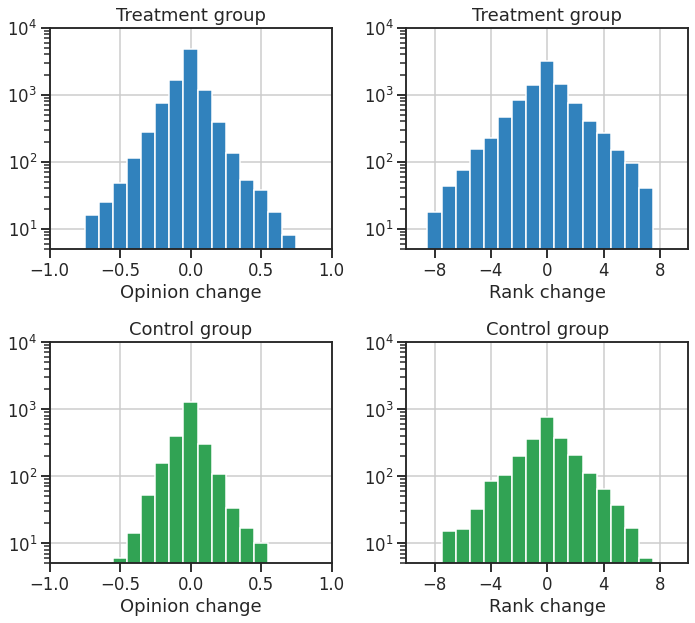

In [16]:
sns.set('talk')
sns.set_style('ticks')
import matplotlib.colors

pad  = 7
colors = [plt.cm.tab20c(0),plt.cm.tab20c(2),plt.cm.tab20c(8),plt.cm.tab20c(10)]
colors = [plt.cm.tab20c(0),plt.cm.tab20c(0),plt.cm.tab20c(8),plt.cm.tab20c(8)]

delta_column = 'delta_score'

fig, axs = plt.subplots(2,2,figsize=(10,9))
axs = axs.T.flatten()

ax = axs[0]
df_deltas_treatment[delta_column].hist(bins=bins_opinion, ax=ax, color=colors[0])
ax.set_title(r'Treatment group', pad=pad)

ax = axs[1]
df_deltas_control[delta_column].hist(bins=bins_opinion, ax=ax, color=colors[2])
ax.set_title('Control group', pad=pad)

for ax in axs[:2]:
    ax.set_xlim(-.8,.8)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Opinion change')
    ax.set_xticks(np.arange(-1,1.5,.5))
    ax.set_yscale('log')


delta_column = 'delta_ranking'

ax = axs[2]
df_deltas_treatment[delta_column].hist(bins=bins_ranking, ax=ax, color=colors[1])
ax.set_title('Treatment group', pad=pad)

ax = axs[3]
df_deltas_control[delta_column].hist(bins=bins_ranking, ax=ax, color=colors[3])
ax.set_title('Control group', pad=pad)

for ax in axs[2:]:
    ax.set_xlim(-10,10)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Rank change')
    ax.set_xticks(np.arange(-8,10,4))
    ax.set_yscale('log')   
    
plt.tight_layout()
plt.savefig('images/Fig-distributions-with-outliers.png')
plt.show()

# If we want to add text to the figures, here's some sample code
# ax.text(-8, 600, "D.", fontsize=20, weight="bold", bbox=dict(facecolor='w', alpha=1.0))

# Test Laplace distribution

In [62]:
datas  = [ df_deltas_control['delta_score'], df_deltas_control['delta_ranking'], df_deltas_treatment['delta_score'], df_deltas_treatment['delta_ranking'] ]
titles = [ 'Control group, Opinion change', 'Control group, Rank change', 'Treatment, Opinion change', 'Treatment group, Rank change']

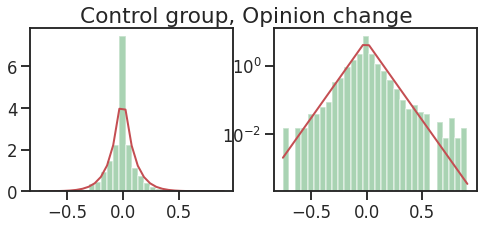

Mean: -0.00665207185776659, Median: -0.002355293177747575
K-S statistic: 0.09340384782483191, p-value: 1.9107717406639015e-18
Sample does not look like it was drawn from a Laplace distribution (reject H0)


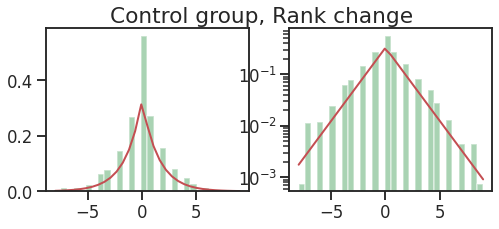

Mean: -0.0008438818565400844, Median: 0.0
K-S statistic: 0.16103516953565628, p-value: 3.664365165945586e-54
Sample does not look like it was drawn from a Laplace distribution (reject H0)


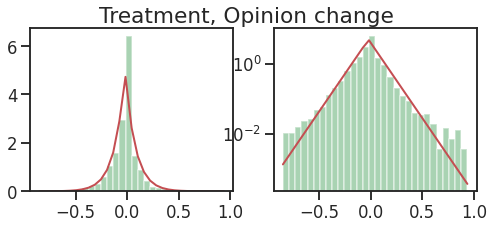

Mean: -0.02098813248574916, Median: -0.0060240963855421326
K-S statistic: 0.10788112808663547, p-value: 1.8953687567938415e-97
Sample does not look like it was drawn from a Laplace distribution (reject H0)


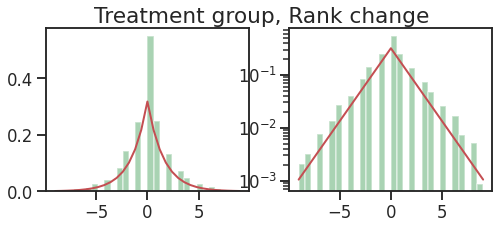

Mean: -0.0005224660397074191, Median: 0.0
K-S statistic: 0.1665009154007704, p-value: 2.3764034332070475e-232
Sample does not look like it was drawn from a Laplace distribution (reject H0)


In [63]:
from scipy.stats import laplace, kstest

nbins = 30

# Sample data that you believe follows a Laplace distribution
#data = np.random.laplace(loc=0.0, scale=1.0, size=1000)
for data,title in zip(datas,titles):

    # Visual Inspection
    fig, axs = plt.subplots(1,2,figsize=(8,3))

    count, bins, ignored = axs[0].hist(data, bins=nbins, density=True, alpha=0.5, color='g')
    count, bins, ignored = axs[1].hist(data, bins=nbins, density=True, alpha=0.5, color='g')
    
    # Fit the Laplace distribution to our data and plot the PDF over our histogram
    mu, b = np.mean(data), np.std(data) / np.sqrt(2)
    pdf = laplace.pdf(bins, loc=mu, scale=b)

    axs[0].plot(bins, pdf, linewidth=2, color='r')
    axs[1].plot(bins, pdf, linewidth=2, color='r')
    
    fig.suptitle(title)

    axs[1].set_yscale('log')
    plt.show()

    # Descriptive Statistics
    print(f"Mean: {np.mean(data)}, Median: {np.median(data)}")

    # Goodness-of-Fit Test (Kolmogorov-Smirnov test)
    d, p_value = kstest(data, 'laplace', args=(mu, b))
    print(f"K-S statistic: {d}, p-value: {p_value}")

    # Interpret the p-value
    alpha = 0.05
    if p_value > alpha:
        print('Sample looks like it was drawn from a Laplace distribution (fail to reject H0)')
    else:
        print('Sample does not look like it was drawn from a Laplace distribution (reject H0)')


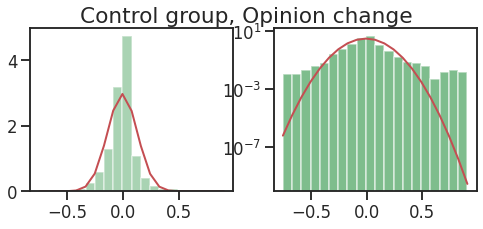

Mean: -0.00665207185776659, Standard Deviation: 0.13404562498750028
K-S statistic: 0.1434273395482043, p-value: 5.249656789786686e-43
Shapiro-Wilk statistic: 0.8742092847824097, p-value: 4.103534396959508e-40

K-S test: Sample does not look like it was drawn from a normal distribution (reject H0)
Shapiro-Wilk test: Sample does not look like it was drawn from a normal distribution (reject H0)


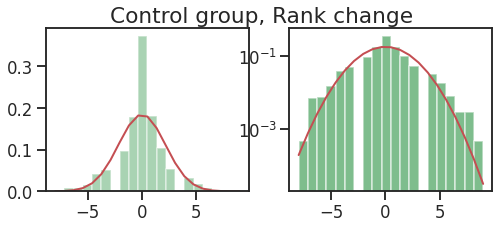

Mean: -0.0008438818565400844, Standard Deviation: 2.1639546459675025
K-S statistic: 0.16091507001086708, p-value: 4.411224086858872e-54
Shapiro-Wilk statistic: 0.9523448348045349, p-value: 4.064962496376964e-27

K-S test: Sample does not look like it was drawn from a normal distribution (reject H0)
Shapiro-Wilk test: Sample does not look like it was drawn from a normal distribution (reject H0)


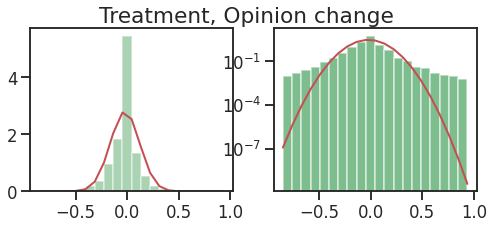

Mean: -0.02098813248574916, Standard Deviation: 0.14215034238712848
K-S statistic: 0.13230060364182317, p-value: 1.5813818627631835e-146
Shapiro-Wilk statistic: 0.887350857257843, p-value: 0.0

K-S test: Sample does not look like it was drawn from a normal distribution (reject H0)
Shapiro-Wilk test: Sample does not look like it was drawn from a normal distribution (reject H0)


/home/chico/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


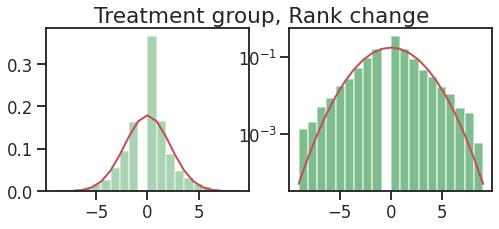

Mean: -0.0005224660397074191, Standard Deviation: 2.2285081155033155
K-S statistic: 0.16657313602616608, p-value: 1.490834643901951e-232
Shapiro-Wilk statistic: 0.9438070058822632, p-value: 0.0

K-S test: Sample does not look like it was drawn from a normal distribution (reject H0)
Shapiro-Wilk test: Sample does not look like it was drawn from a normal distribution (reject H0)


/home/chico/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [64]:
from scipy.stats import norm, kstest, shapiro

for data,title in zip(datas,titles):

    # Visual Inspection
    fig, axs = plt.subplots(1,2,figsize=(8,3))

    count, bins, ignored = axs[0].hist(data, bins=20, density=True, alpha=0.5, color='g')
    count, bins, ignored = axs[1].hist(data, bins=20, density=True, alpha=0.5, color='g')

    # Let's assume 'data' contains our dataset
    # data = ...

    # Visual Inspection
    count, bins, ignored = plt.hist(data, bins=20, density=True, alpha=0.5, color='g')
    # Fit the normal distribution to our data and plot the PDF over our histogram
    mu, sigma = np.mean(data), np.std(data)
    pdf = norm.pdf(bins, mu, sigma)

    axs[0].plot(bins, pdf, linewidth=2, color='r')
    axs[1].plot(bins, pdf, linewidth=2, color='r')
    
    fig.suptitle(title)

    axs[1].set_yscale('log')
    plt.show()
    
    
    # Descriptive Statistics
    print(f"Mean: {mu}, Standard Deviation: {sigma}")

    # Goodness-of-Fit Test (Kolmogorov-Smirnov test)
    d, p_value = kstest(data, 'norm', args=(mu, sigma))
    print(f"K-S statistic: {d}, p-value: {p_value}")

    # Normality Test (Shapiro-Wilk test)
    stat, p_value_shapiro = shapiro(data)
    print(f"Shapiro-Wilk statistic: {stat}, p-value: {p_value_shapiro}")

    print()
    # Interpret the p-values
    alpha = 0.05
    if p_value > alpha:
        print('K-S test: Sample looks like it was drawn from a normal distribution (fail to reject H0)')
    else:
        print('K-S test: Sample does not look like it was drawn from a normal distribution (reject H0)')

    if p_value_shapiro > alpha:
        print('Shapiro-Wilk test: Sample looks like it was drawn from a normal distribution (fail to reject H0)')
    else:
        print('Shapiro-Wilk test: Sample does not look like it was drawn from a normal distribution (reject H0)')


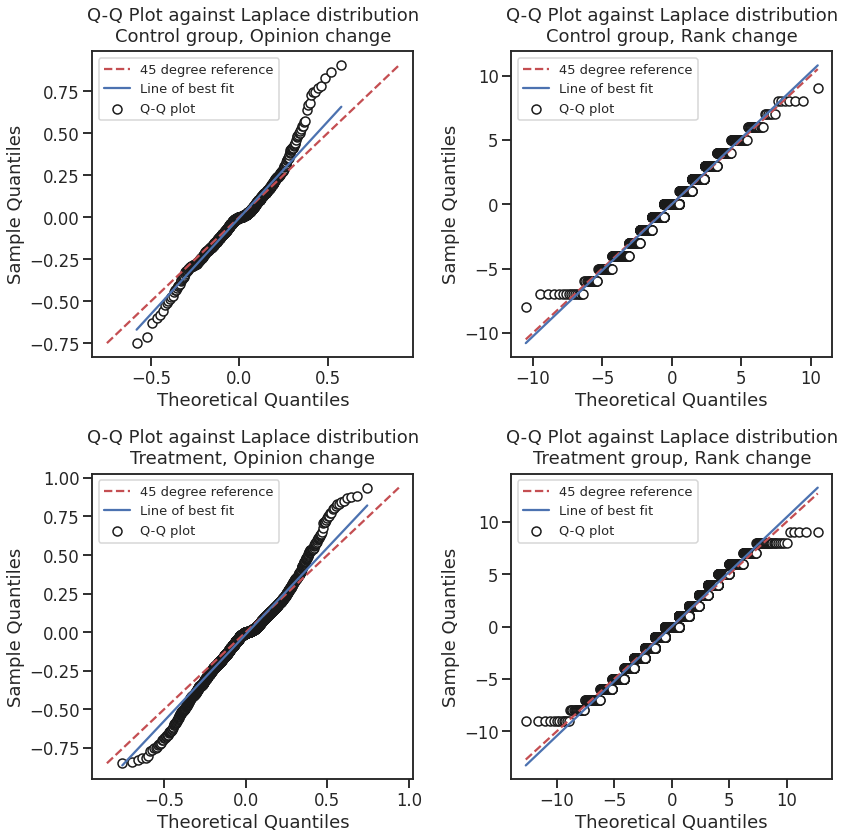

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace, probplot


fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

for ax,data,title in zip(axs,datas,titles):
    
    #x = (data-np.mean(data))/np.std(data)
    
    # Estimate the parameters of the Laplace distribution from the data
    location, scale = laplace.fit(data)

    # Function to calculate Laplace quantiles
    def laplace_quantiles(probs, loc, scale):
        return loc - scale * np.sign(probs - 0.5) * np.log(1 - 2 * np.abs(probs - 0.5))

    # Calculate the empirical quantiles
    probs = np.linspace(0, 1, len(data)+2)[1:-1]  # Avoid 0 and 1
    data_sorted = np.sort(data)

    # Calculate the theoretical Laplace quantiles using the estimated parameters
    theoretical_quantiles = laplace_quantiles(probs, location, scale)

    # Create the Q-Q plot
    ax.scatter(theoretical_quantiles, data_sorted, edgecolor='k', facecolor='white')
    ax.set_title('Q-Q Plot against Laplace distribution\n'+title, pad=10)
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

    # Add the 45-degree reference line
    min_quantile = min(data_sorted[0], theoretical_quantiles[0])
    max_quantile = max(data_sorted[-1], theoretical_quantiles[-1])
    ax.plot([min_quantile, max_quantile], [min_quantile, max_quantile], 'r--')

    # Add the line of best fit
    m, b = np.polyfit(theoretical_quantiles, data_sorted, 1)
    ax.plot(theoretical_quantiles, m*theoretical_quantiles + b, 'b-')
    
    legend =['45 degree reference','Line of best fit','Q-Q plot']
    ax.legend(legend, fontsize=13)

plt.tight_layout()
plt.savefig('images/qq-plots-against-laplace.png')
plt.show()

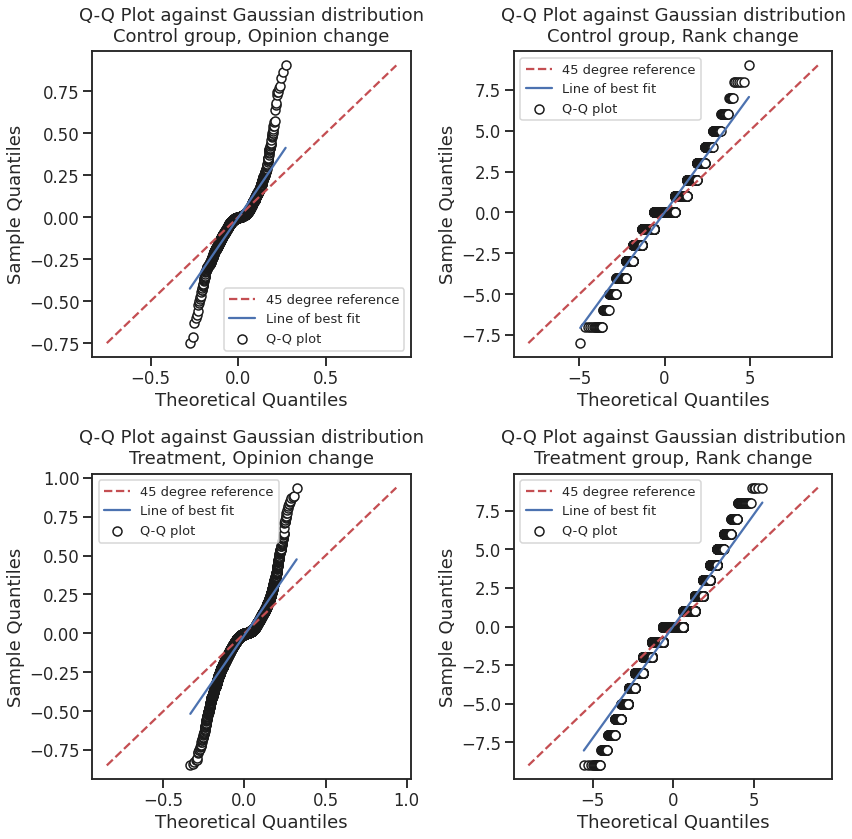

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

for ax,data,title in zip(axs,datas,titles):
    
    #x = (data-np.mean(data))/np.std(data)
    
    # Estimate the parameters of the Laplace distribution from the data
    location, scale = laplace.fit(data)

    # Function to calculate Gaussian (Normal) quantiles
    def gaussian_quantiles(probs, mu, sigma):
        return norm.ppf(probs, loc=mu, scale=sigma)

    # Calculate the empirical quantiles
    probs = np.linspace(0, 1, len(data)+2)[1:-1]  # Avoid 0 and 1
    data_sorted = np.sort(data)

    # Calculate the theoretical Laplace quantiles using the estimated parameters
    theoretical_quantiles = gaussian_quantiles(probs, location, scale)

    # Create the Q-Q plot
    ax.scatter(theoretical_quantiles, data_sorted, edgecolor='k', facecolor='white')
    ax.set_title('Q-Q Plot against Gaussian distribution\n'+title, pad=10)
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

    # Add the 45-degree reference line
    min_quantile = min(data_sorted[0], theoretical_quantiles[0])
    max_quantile = max(data_sorted[-1], theoretical_quantiles[-1])
    ax.plot([min_quantile, max_quantile], [min_quantile, max_quantile], 'r--')

    # Add the line of best fit
    m, b = np.polyfit(theoretical_quantiles, data_sorted, 1)
    ax.plot(theoretical_quantiles, m*theoretical_quantiles + b, 'b-')
    
    legend =['45 degree reference','Line of best fit','Q-Q plot']
    ax.legend(legend, fontsize=13)

plt.tight_layout()
plt.savefig('images/qq-plots-against-gaussian.png')
plt.show()

### Interpretation:
https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html